Map the position of the flux

# Imports

In [2]:
import cmocean.cm as cm
import glob
from matplotlib.colors import LogNorm, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp

#from salishsea_tools import nc_tools

%matplotlib inline

# Get Grid Info Data

In [3]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdepw_1d)
figrid = 386
igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
f_lons = mymesh.glamf[0, igrid]
w_depths = mymesh.gdepw_1d

# Twelve Hours : 01sep15

In [3]:
file = '/data/sallen/results/Ariane/BackNorth/01apr15/ariane_positions_quantitative.nc'
tidefile = '/results/SalishSea/nowcast-green/01apr15/PointAtkinson.nc'

In [4]:
def get_data(mydata, section, time):
    lons = mydata.init_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.init_z[(mydata.final_section==section) & (mydata.init_t==time)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section==section) & (mydata.init_t==time)]
    return lons, depths, transports

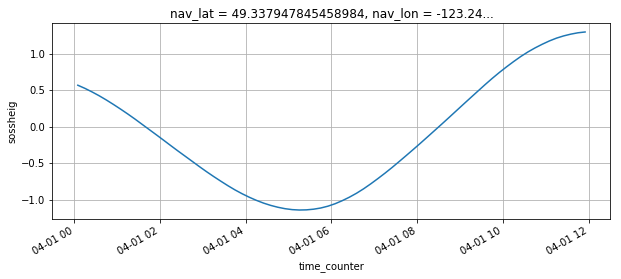

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
with xr.open_dataset(tidefile) as tidedata:
    tidedata.sossheig[0:72].plot(ax=ax)
ax.grid(which='both')

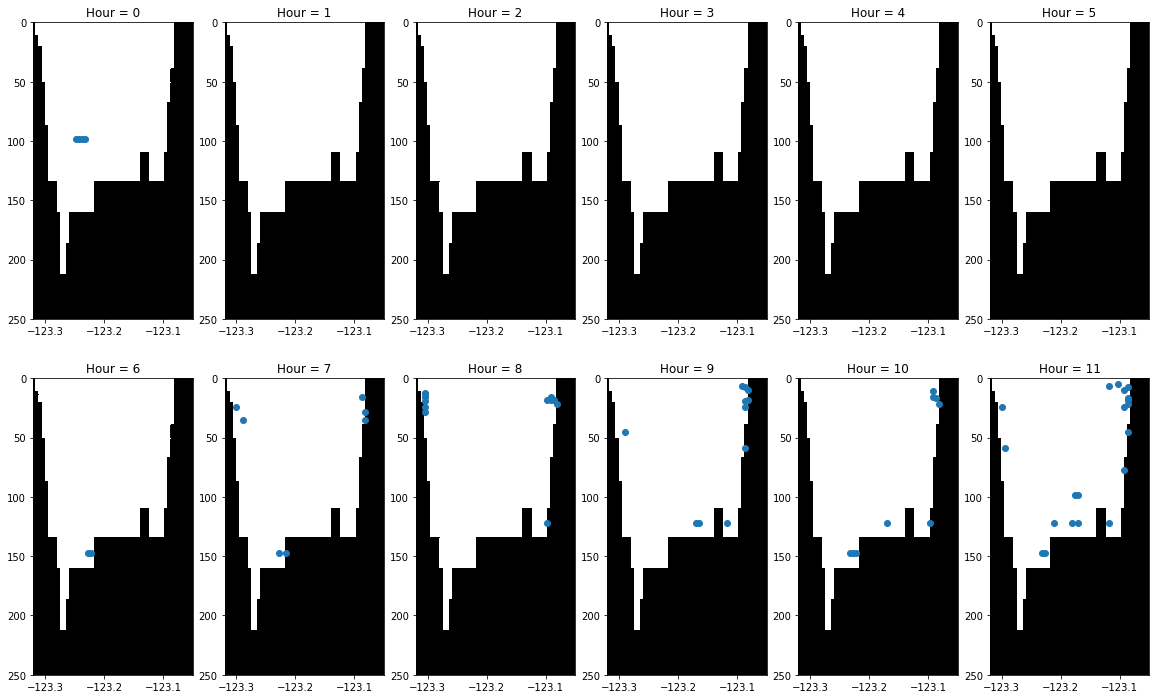

In [6]:
mydata = xr.open_dataset(file)
section = 2
time1 = mydata.init_t[0]
fig, axs = plt.subplots(2, 6, figsize=(20, 12))
x, y = np.meshgrid(u_lons, w_depths)
for hour in range(12):
    ax = axs[int(hour/6), hour-6*int(hour/6)]
    lons, depths, transports = get_data(mydata, section, time1+hour)
    ax.pcolormesh(x, y, fmask, cmap='Greys_r')
    ax.plot(lons, depths, 'o')
    ax.invert_yaxis()
    ax.set_xlim((-123.32, -123.05))
    ax.set_ylim((250, 0))
    ax.set_title("Hour = "+str(hour))

# Fifteen Days 01apr15-15apr15

In [7]:
sevendays = (sorted(glob.glob('/data/sallen/results/Ariane/BackNorth/0*apr15/ariane_positions_quantitative.nc')) +
            sorted(glob.glob('/data/sallen/results/Ariane/BackNorth/1[012345]apr15/ariane_positions_quantitative.nc')))
tidefile = (sorted(glob.glob('/results/SalishSea/nowcast-green/0*apr15/PointAtkinson.nc')) +
            sorted(glob.glob('/results/SalishSea/nowcast-green/1[012345]apr15/PointAtkinson.nc')))
salfile = (sorted(glob.glob('/results/SalishSea/nowcast-green/0*apr15/SalishSea_1d_2015040*_2015040*_grid_T.nc')) +
           sorted(glob.glob('/results/SalishSea/nowcast-green/1[012345]apr15/SalishSea_1d_2015041[012345]_2015041[012345]_grid_T.nc')))

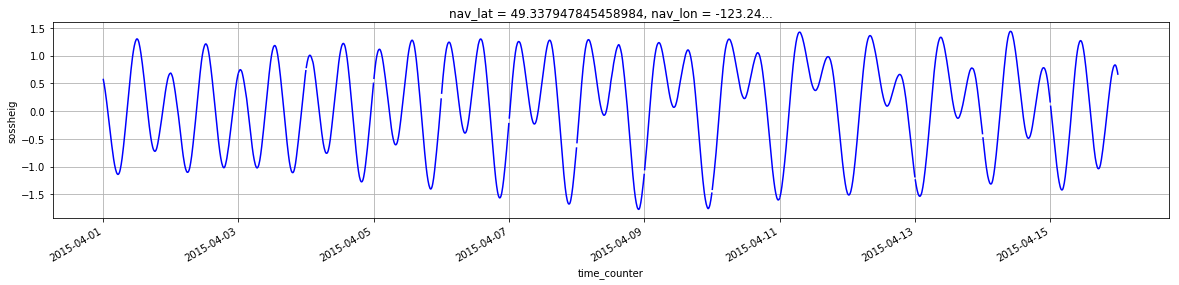

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
for file in tidefile:
    with xr.open_dataset(file) as tidedata:
        tidedata.sossheig.plot(ax=ax, color='b')
ax.grid(which='both')

In [12]:
def draw_patches(fmask, ll, ul, u_lons, w_depths):
    topo = []
    for i in range(ll,ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood')
    return(pc)

NameError: name 'sevendays' is not defined

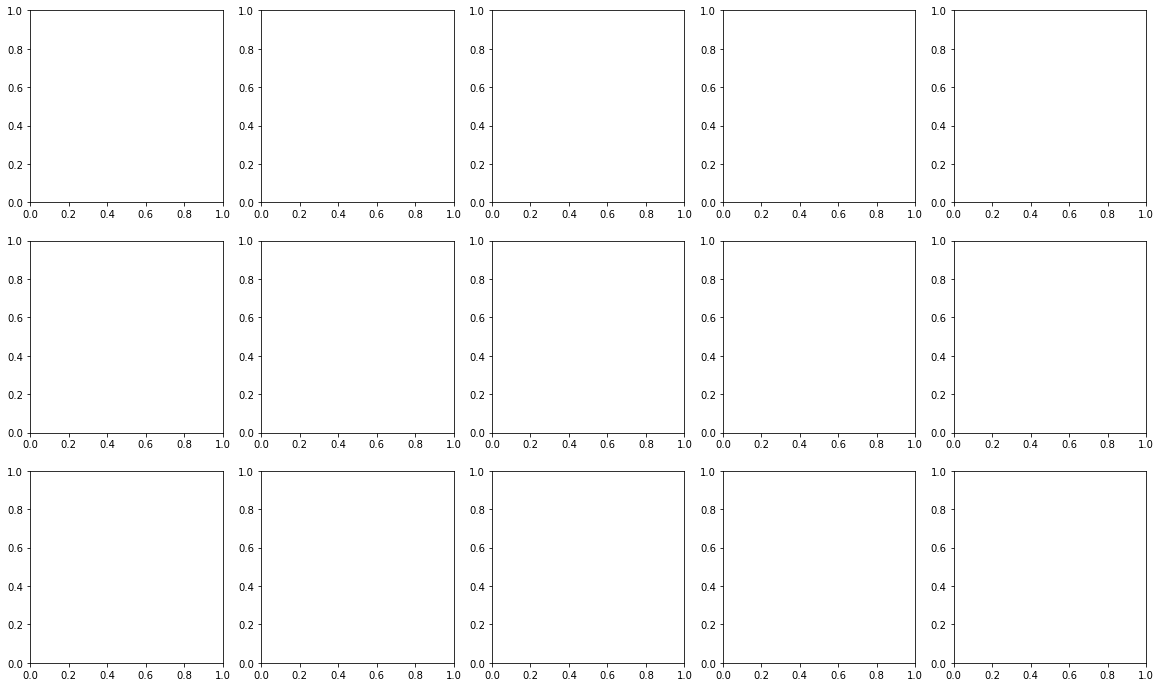

In [10]:
section = 2
m2lon = ((u_lons[314]-u_lons[260])/(mymesh.e2f[0, igrid, 260:314].sum()))
tmax = 1378670
vvmax = 0.15/float(m2lon)*24/tmax
xs, ys = np.meshgrid(np.array(mymesh.glamv[0, igrid]), np.array(mymesh.gdept_1d))
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
for day, f in enumerate(sevendays):
    ax = axs[int(day/5), day-5*int(day/5)]
    mydata = xr.open_dataset(f)
    lons = mydata.init_lon[(mydata.final_section==section)]
    depths = depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section==section)]
    print (day, float(transports.sum()))
    vmax = vvmax*tmax/float(transports.sum())
    c, xedge, yedge, im = ax.hist2d(lons, 
                                depths,
                                weights=transports,
                                bins=[np.array(f_lons[260:314]), w_depths[0]], cmap=cm.amp, 
                                    normed=True, vmax=vmax)
    pc = draw_patches(fmask, 260, 314, np.array(u_lons), np.array(w_depths[0]))
    ax.add_collection(pc)
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, f'{vmax * float(m2lon) * float(transports.sum())/24.:.2f}'])
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile[day]).vosaline[0, :, igrid],
                       mask=1-tmask[:, igrid]) +
                    np.ma.array(xr.open_dataset(salfile[day]).vosaline[0, :, igrid+1],
                       mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    ax.set_xlim((-123.32, -123.05))
    ax.set_ylim((250, 0))
    ax.set_title("Day, April "+str(day+1))
    mydata.close()

In [11]:
print(mymesh.e2f[0, igrid, 260:314].sum())
print(u_lons[314] - u_lons[260])

<xarray.DataArray 'e2f' ()>
array(27069.478638769964)
<xarray.DataArray 'glamv' ()>
array(0.28084564208984375, dtype=float32)


In [12]:
print (c.shape, mymesh.e3t_1d[0,0:39].shape)
print (mymesh.gphiv[0, igrid, 260])
print (m2lon)
print (((c*np.array(mymesh.e3t_1d[0,0:39])).transpose()*np.array(mymesh.e2f[0, igrid, 260:314-1])).sum()
       *m2lon * transports.sum())

(53, 39) (39,)
<xarray.DataArray 'gphiv' ()>
array(48.877899169921875, dtype=float32)
<xarray.DataArray ()>
array(1.037499265640106e-05)
<xarray.DataArray ()>
array(231492.2767399414)


In [13]:
mt = 38704 # m3/s
tt = mt*86400 #m3
print(tt/1e6)
transports.sum()*3600/1e6

3344.0256


<xarray.DataArray 'init_transp' ()>
array(833.0925769029589)

# Month of April

In [4]:
# v3 fluxes but earlier version of monthly average salinities
amonth = glob.glob('/data/sallen/results/Ariane/BackNorth/*apr15/ariane_positions_quantitative.nc')
salinity = 0.5*(np.ma.array(xr.open_dataset('/data/sallen/results/Ariane/Salinity/SalishSea_1month_201504_grid_T.nc').vosaline[0, :, igrid],
                       mask=1-tmask[:, igrid]) +
                    np.ma.array(xr.open_dataset('/data/sallen/results/Ariane/Salinity/SalishSea_1month_201504_grid_T.nc').vosaline[0, :, igrid+1],
                       mask=1-tmask[:, igrid+1]))

In [5]:
section = 2
mydata = xr.open_dataset(amonth[0])
lons = mydata.init_lon[(mydata.final_section==section)]
depths = depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]
transports = mydata.init_transp[(mydata.final_section==section)]
for f in amonth[1:]:
    mydata = xr.open_dataset(f)
    lons = np.concatenate((lons, mydata.init_lon[(mydata.final_section==section)]))
    depths = np.concatenate((depths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]))
    transports = np.concatenate((transports, mydata.init_transp[(mydata.final_section==section)]))

In [6]:
amonth = glob.glob('/data/sallen/results/Ariane/InGIslands/*apr15/ariane_positions_quantitative.nc')
section = 2
for f in amonth:
    mydata = xr.open_dataset(f)
    lons = np.concatenate((lons, mydata.init_lon[(mydata.final_section==section)]))
    depths = np.concatenate((depths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]))
    transports = np.concatenate((transports, mydata.init_transp[(mydata.final_section==section)]))

In [7]:
amonth = glob.glob('/data/sallen/results/Ariane/FullNorth/*apr15/ariane_positions_quantitative.nc')
section = 2
mydata = xr.open_dataset(amonth[0])
olons = mydata.init_lon[(mydata.final_section==section)]
odepths = depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]
otransports = mydata.init_transp[(mydata.final_section==section)]
for f in amonth[1:]:
    mydata = xr.open_dataset(f)
    olons = np.concatenate((olons, mydata.init_lon[(mydata.final_section==section)]))
    odepths = np.concatenate((odepths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]))
    otransports = np.concatenate((otransports, mydata.init_transp[(mydata.final_section==section)]))

In [8]:
amonth = glob.glob('/data/sallen/results/Ariane/SouthGIslands/*apr15/ariane_positions_quantitative.nc')
section = 2
for f in amonth:
    mydata = xr.open_dataset(f)
    olons = np.concatenate((olons, mydata.init_lon[(mydata.final_section==section)]))
    odepths = np.concatenate((odepths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]))
    otransports = np.concatenate((otransports, mydata.init_transp[(mydata.final_section==section)]))

In [ ]:
walrus = olons[olons > -123.4]
myw =  walrus[walrus < -123.3]
print (myw[0:20])

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  # Remove the CWD from sys.path while we load stuff.
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.


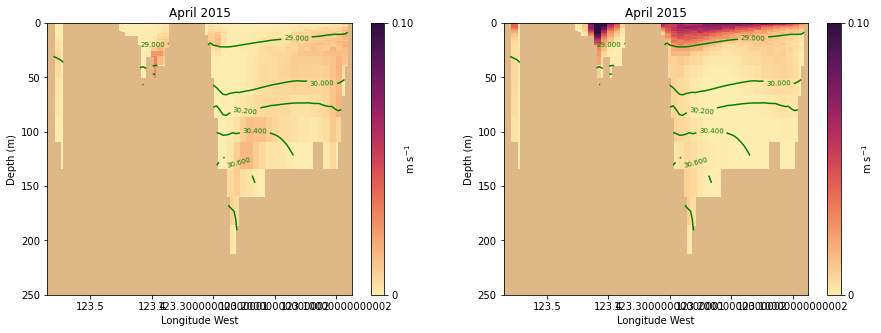

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
vmax = 0.22 / transports.sum() * 31097863.7006
v2max = 0.22 / otransports.sum() * 31097863.7006
jmin = 210
gridding = 2
c, xedge, yedge, im = axs[0].hist2d(lons, 
                                depths,
                                weights=transports,
                                bins=[np.array(f_lons[jmin:314:gridding]), w_depths[0]], cmap=cm.matter, 
                                    normed=True, vmax=vmax)
yes = yedge.copy()
CS = axs[0].contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
axs[0].clabel(CS, inline=1, fontsize=7)
pc = draw_patches(fmask, jmin, 314, np.array(u_lons), np.array(w_depths[0]))
axs[0].add_collection(pc)
cb1 = fig.colorbar(im, ax=axs[0]) 
cb1.set_ticks([0, vmax])

cb1.set_label('m s$^{-1}$', labelpad=-10)
c, xedge, yedge, im = axs[1].hist2d(olons, 
                                odepths,
                                weights=otransports,
                                bins=[np.array(f_lons[jmin:314:gridding]), w_depths[0]], cmap=cm.matter, 
                                    normed=True, vmax=v2max)
CS = axs[1].contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
axs[1].clabel(CS, inline=1, fontsize=7)
pc = draw_patches(fmask, jmin, 314, np.array(u_lons), np.array(w_depths[0]))
axs[1].add_collection(pc)
cb2 = fig.colorbar(im, ax=axs[1]) 
cb2.set_ticks([0, v2max])
cb2.set_label('m s$^{-1}$', labelpad=-10)
for ax in axs:
    ax.invert_yaxis()
    ax.set_xlim((-123.57, -123.075))
    ax.set_ylim((250, 0))
    ax.set_xticks(np.arange(-123.5, -123.1, 0.1))
    ax.set_xticklabels(np.arange(123.5, 123.1, -0.1))
    ax.set_xlabel('Longitude West')
    ax.set_ylabel('Depth (m)')
    ax.set_title("April 2015")
cb1.set_ticklabels([0, f'{vmax * float(m2lon) * transports.sum()/24/30:.2f}'])
cb2.set_ticklabels([0, f'{v2max * float(m2lon) * float(otransports.sum())/24./30.:.2f}'])

In [59]:
yedge

array([   0.        ,    1.00000123,    2.00000639,    3.00001921,
          4.00004695,    5.00010374,    6.00021712,    7.00044072,
          8.00087898,    9.00173537,   10.00340608,   11.00666275,
         12.01300785,   13.02536622,   14.04942854,   15.09625559,
         16.18730348,   17.36403385,   18.7059723 ,   20.36347338,
         22.61306387,   25.93741305,   31.10103509,   39.1188566 ,
         50.96323669,   67.05207424,   86.96747037,  109.73706598,
        134.34593444,  160.02956159,  186.30527815,  212.89655735,
        239.65304462,  266.49521437,  293.38160496,  320.29076029,
        347.21161956,  374.1384921 ,  401.06845307,  428.        ])

In [45]:
print(mydata.init_lat, mydata.init_x, mydata.init_y)

<xarray.DataArray 'init_lat' (ntraj: 26047)>
array([ 48.893097,  48.963257,  48.963257, ...,  48.901167,  48.901167,
        48.902592])
Dimensions without coordinates: ntraj
Attributes:
    title:     What is init_lat ?
    longname:  Initial position in latitude
    units:     No dimension <xarray.DataArray 'init_x' (ntraj: 26047)>
array([ 268.5 ,  305.5 ,  305.5 , ...,  272.75,  272.75,  273.5 ])
Dimensions without coordinates: ntraj
Attributes:
    title:     What is init_x ?
    longname:  Initial position in i
    units:     No dimension <xarray.DataArray 'init_y' (ntraj: 26047)>
array([ 386.,  386.,  386., ...,  386.,  386.,  386.])
Dimensions without coordinates: ntraj
Attributes:
    title:     What is init_y ?
    longname:  Initial position in j
    units:     No dimension


In [48]:
0.5*(mymesh.nav_lat[386-1, 268-1]+mymesh.nav_lat[386-1, 269-1])

<xarray.DataArray 'nav_lat' ()>
array(48.89017868041992)

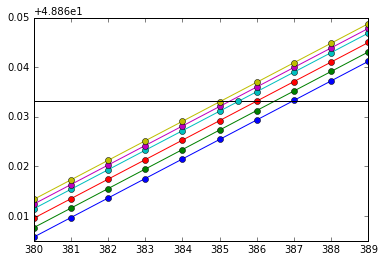

In [61]:
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 265], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 266], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 267], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 268], '-o')
plt.plot(range(380, 390), 0.5*(mymesh.nav_lat[380:390, 268]+mymesh.nav_lat[380:390, 269]), '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 269], '-o')
plt.plot(range(380, 390), 48.893097*np.ones(10))
plt.plot(385.5, 0.5*(mymesh.nav_lat[385, 268]+mymesh.nav_lat[386, 268]), '-co')

In [ ]:
Choices: 385 and 269
    385.5 and 268
    386 and 267
and its saying 268.5 and 386    

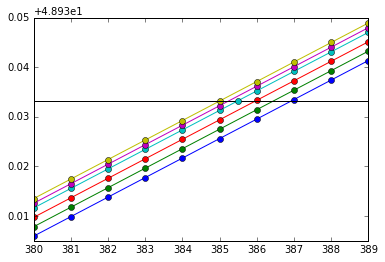

In [62]:
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 302], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 303], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 304], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 305], '-o')
plt.plot(range(380, 390), 0.5*(mymesh.nav_lat[380:390, 305]+mymesh.nav_lat[380:390, 306]), '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 306], '-o')
plt.plot(range(380, 390), 48.963257*np.ones(10))
plt.plot(385.5, 0.5*(mymesh.nav_lat[385, 305]+mymesh.nav_lat[386, 305]), '-co')

26295926400